In [160]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [174]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV

In [162]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

sns.set_style("darkgrid")
sns.set_context(rc={"figure.figsize": (6, 3)})

In [4]:
# load in train and test data

dfs = {}
for name in ['train', 'test']:
    df = pd.read_csv('../data/%s.csv' % name)
    df['data'] = name
    dfs[name] = df

In [44]:
# basic info about columns in each dataset

for name, df in dfs.iteritems():
    print 'df: %s\n' % name
    print 'shape: %d rows, %d cols\n' % df.shape
    
    print 'column info:'
    for col in df.columns:
        print '* %s: %d nulls, %d unique vals, most common: %s' % (
            col, 
            df[col].isnull().sum(),
            df[col].nunique(),
            df[col].value_counts().head(2).to_dict()
        )
    print '\n------\n'

df: test

shape: 418 rows, 12 cols

column info:
* PassengerId: 0 nulls, 418 unique vals, most common: {1128: 1, 1023: 1}
* Pclass: 0 nulls, 3 unique vals, most common: {1: 107, 3: 218}
* Name: 0 nulls, 418 unique vals, most common: {'Rosenbaum, Miss. Edith Louise': 1, 'Beauchamp, Mr. Henry James': 1}
* Sex: 0 nulls, 2 unique vals, most common: {'male': 266, 'female': 152}
* Age: 86 nulls, 79 unique vals, most common: {24.0: 17, 21.0: 17}
* SibSp: 0 nulls, 7 unique vals, most common: {0: 283, 1: 110}
* Parch: 0 nulls, 8 unique vals, most common: {0: 324, 1: 52}
* Ticket: 0 nulls, 363 unique vals, most common: {'PC 17608': 5, '113503': 4}
* Fare: 1 nulls, 169 unique vals, most common: {7.75: 21, 26.0: 19}
* Cabin: 327 nulls, 76 unique vals, most common: {'B57 B59 B63 B66': 3, 'C101': 2}
* Embarked: 0 nulls, 3 unique vals, most common: {'S': 270, 'C': 102}
* data: 0 nulls, 1 unique vals, most common: {'test': 418}

------

df: train

shape: 891 rows, 13 cols

column info:
* PassengerId: 

In [163]:
# combine train and test data into one df
df = dfs['train'].append(dfs['test'])

# lowercase column names
df.columns = map(str.lower, df.columns)

# reorder columns
new_col_order = ['data', 'passengerid', 'survived', 'age',
                'cabin', 'embarked', 'fare', 'name', 'parch',
                'pclass', 'sex', 'sibsp', 'ticket']
df = df[new_col_order]

df.head()

,data,passengerid,survived,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,ticket
0,train,1,0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,A/5 21171
1,train,2,1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,PC 17599
2,train,3,1,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,STON/O2. 3101282
3,train,4,1,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,113803
4,train,5,0,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,373450


In [164]:
# convert sex to ints (male = 1, female = 0)
df['gender'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)

# extract title
df['title'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# fill missing age with mean by title
age_by_title = df.groupby('title')['age'].agg(np.mean).to_dict()
df['age'] = df.apply(lambda row: age_by_title.get(row['title']) 
                     if pd.isnull(row['age']) else row['age'], axis=1)

# fill missing fare with median by pclass
# some people have a fare = 0, so only look at those > 0
fare_by_pclass = df[df['fare'] > 0].groupby('pclass')['fare'].agg(np.median).to_dict()
df['fare'] = df.apply(lambda r: r['fare'] if r['fare'] > 0 
                      else fare_by_pclass.get(r['pclass']), axis=1)

# fill missing embarked with most common port
most_common_port = df['embarked'].mode()[0]
df['embarked'] = df['embarked'].fillna(most_common_port)

# transform categorical embarked column to 1/0 dummy columns
dummies = pd.get_dummies(df['embarked'], prefix='port')
df = pd.concat([df, dummies], axis=1)

df.iloc[0]

data                             train
passengerid                          1
survived                             0
age                                 22
cabin                              NaN
embarked                             S
fare                              7.25
name           Braund, Mr. Owen Harris
parch                                0
pclass                               3
sex                               male
sibsp                                1
ticket                       A/5 21171
gender                               1
title                               Mr
port_C                               0
port_Q                               0
port_S                               1
Name: 0, dtype: object

In [165]:
# drop unnecessary columns
drop_cols = ['cabin', 'name', 'sex', 'ticket', 'title', 'embarked']
df = df.drop(drop_cols, axis=1)

df.head()

,data,passengerid,survived,age,fare,parch,pclass,sibsp,gender,port_C,port_Q,port_S
0,train,1,0,22,7.2500,0,3,1,1,0,0,1
1,train,2,1,38,71.2833,0,1,1,0,1,0,0
2,train,3,1,26,7.9250,0,3,0,0,0,0,1
3,train,4,1,35,53.1000,0,1,1,0,0,0,1
4,train,5,0,35,8.0500,0,3,0,1,0,0,1


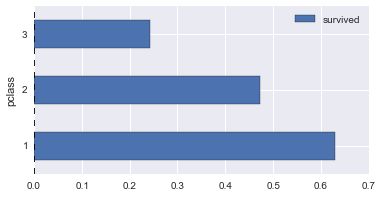

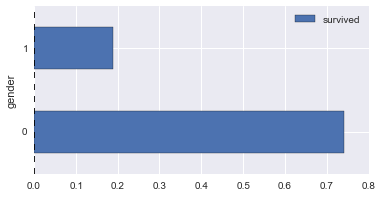

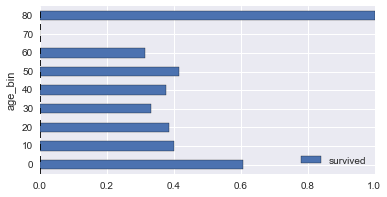

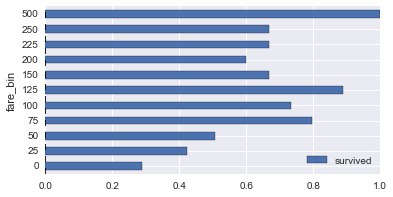

In [166]:
# survival rates across various columns

def plot_survive_rate(df, col, chart='barh'):
    survive_rates = df.groupby(col).agg({
        'survived': lambda x : sum(x) / len(x)
    })
    survive_rates.plot(kind=chart);

def bin_num(x, base=5):
    return int(x - (x % base))
    
# get cleaned training data
dg = df[df['data'] == 'train'].copy()

# discretize age & fare
dg['age_bin'] = dg['age'].apply(lambda x: bin_num(x, 10))
dg['fare_bin'] = dg['fare'].apply(lambda x: bin_num(x, 25))

for col in ['pclass', 'gender', 'age_bin', 'fare_bin']:
    plot_survive_rate(dg, col)

In [167]:
# store the columns (features) to be used in classification
x_cols = df.columns.values[3:]

print '%d total features' % len(x_cols)
print x_cols

9 total features
['age' 'fare' 'parch' 'pclass' 'sibsp' 'gender' 'port_C' 'port_Q' 'port_S']


In [168]:
# prep training data for classifying
# (separating features and metric we're predicting)

df_train = df[df['data'] == 'train']

X = df_train[x_cols].as_matrix()
y = df_train['survived'].as_matrix()

print '%d rows, %d features' % (len(df_train), len(x_cols))

891 rows, 9 features


In [172]:
# cross validation to evaluate model
# (dividing training data into n chunks and training model n times 
# with a different holdout chunk each time)

cv = StratifiedKFold(y, n_folds=6)
tot_correct, tot_obs = 0, 0

for i, (train, test) in enumerate(cv):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]

    model = RandomForestClassifier(random_state=321) 
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    correct, obs = (y_test == y_pred).sum(), len(y_test)
    tot_correct += correct
    tot_obs += obs

print 'accuracy: %f' % (tot_correct * 1.0 / tot_obs)

accuracy: 0.799102


In [173]:
# evaluate model over entire training set 
# and look at each feature's importance

model = RandomForestClassifier(random_state=321)
model.fit(X, y)

feature_rank = pd.Series(model.feature_importances_, index=x_cols).order(ascending=False)
feature_rank

fare      0.265518
age       0.264835
gender    0.259047
pclass    0.078497
sibsp     0.054447
parch     0.046165
port_S    0.011954
port_C    0.011904
port_Q    0.007634
dtype: float64

In [180]:
# model parameter tuning
# (there are several input parameters to a random forest model;
# grid search automates the process of tweaking these parameters to find the 
# optimal values for these parameters)

param_grid = {
    "n_estimators": [100],
    "criterion": ["gini", "entropy"],
    'max_features': [0.5, 1.0, "sqrt"],
    'max_depth': [4, 5, 6, 7, 8, None],
}

model = RandomForestClassifier(random_state=321)
grid_search = GridSearchCV(model, param_grid, cv=12, verbose=0)
grid_search.fit(X, y)

print grid_search.best_score_
print grid_search.best_params_

0.836139169473
{'max_features': 0.5, 'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 7}


In [182]:
# train model with best parameters from grid search
# and finally predict survival of people from test data

df_train = df[df['data'] == 'train'].copy()

X_train = df_train[x_cols].as_matrix()
y_train = df_train['survived'].as_matrix()

model = RandomForestClassifier(
    n_estimators=100, 
    criterion='entropy', 
    max_features=0.5, 
    max_depth=7,
    random_state=321,
)

model.fit(X_train, y_train)

df_test = df[df['data'] == 'test'].copy()

X_test = df_test[x_cols].as_matrix()
y_pred = model.predict(X_test).astype(int)

df_test['survived'] = y_pred

final_df = df_test[['passengerid', 'survived']]
final_df.to_csv('../output/predicted.csv', index=False)
print 'boom.'

boom.
